In [1]:
import math
import time


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.linalg as TLA
from tqdm import tqdm
import pandas as pd

from fastPLNmodels.utils import init_C, init_M, init_Sigma, Poisson_reg, log_stirling, batch_log_P_WgivenY, MSE
from fastPLNmodels.utils import refined_MSE, RMSE, C_from_Sigma
from fastPLNmodels.VRA import SAGARAD, SAGRAD, SVRGRAD 

if torch.cuda.is_available():
    device = torch.device('cuda')
else : 
    device = torch.device('cpu')
#device = torch.device('cpu') # have to deal with this. 
    
print('device ', device)

device  cpu


In [4]:
Y = pd.read_csv('Y_test')
O = pd.read_csv('O_test')
cov = pd.read_csv('cov_test')
true_Sigma = torch.from_numpy(pd.read_csv('true_Sigma_test').values)
true_beta = torch.from_numpy(pd.read_csv('true_beta_test').values)

In [264]:
def sample_gaussians(N_samples, mean,sqrt_Sigma):
    '''Sample some gaussians with the right mean and variance. 
    Be careful, we ask for the square root of Sigma, not Sigma.
    
    Args: 
         N_samples : int. the number of samples you want to sample. 
         mean : torch.tensor of size (n_batch,q) 
         sqrt_Sigma : torch.tensor or size (batch_size, q, q). The square roots matrices 
             of the covariance matrices. (e.g. if you want to sample a gaussian with 
             covariance matrix A, you need to give the square root of A in argument.   
         
    Returns: 
        W: torch.tensor of size (N_samples, batch_size,q). It is a vector 
        of N_samples gaussian of dimension mean.shape. For each  1< i< N_sample,
        1<k< n_batch , W[i,k] is a gaussian with mean mean[k,:] and variance 
        sqrt_Sigma[k,:,:]@sqrt_Sigma[k,:,:].  
    '''
    q = mean.shape[1]
    W_orig = torch.randn(N_samples, 1,q,1).to(device)
    # just add the mean and multiply by the square root matrice to sample from 
    # the right distribution. 
    W = torch.matmul(sqrt_Sigma.unsqueeze(0), W_orig).squeeze() + mean.unsqueeze(0)
    return W

def log_gaussian_density(W, mu_p,Sigma_p): 
    '''Compute the log density of a gaussian W of size 
    (N_samples, n_batch, q) With mean mu_p and Sigma_p.
    
    Args : 
        W: torch.tensor of size (N_samples, batch_size, q)
        mu_p : torch.tensor : the mean from which the gaussian has been sampled.
        Sigma_p : torch.tensor. The variance from which the gaussian has been sampled. 
    Returns : 
        torch.tensor. The log of the density of W, taken along the last axis.  
    '''
    dim = W.shape[-1] # dimension q
    const = torch.sqrt((2*math.pi)**dim*torch.det(Sigma_p)) # Constant of the gaussian density
    Wmoinsmu = W-mu_p.unsqueeze(0)
    inv_Sig = torch.inverse(Sigma_p)
    # Log density of a gaussian. 
    log_d = -1/2*torch.matmul(
                            torch.matmul(inv_Sig.unsqueeze(0), 
                                         Wmoinsmu.unsqueeze(3)).squeeze().unsqueeze(2),
                            Wmoinsmu.unsqueeze(3))
    return log_d.squeeze() - torch.log(const)





In [265]:
imps = IMPS_PLN(5)
imps.fit(Y,O,cov,acc = 0.005, N_epoch_max = 30, nb_plateau = 100)


Intialization ...
Initalization done


100%|██████████| 30/30 [00:10<00:00,  2.85it/s]


Total time : 10.229033946990967


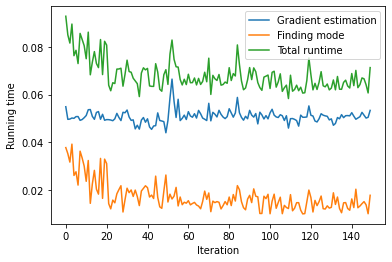

In [266]:
imps.plot_runtime()

nb iteration in total 2675


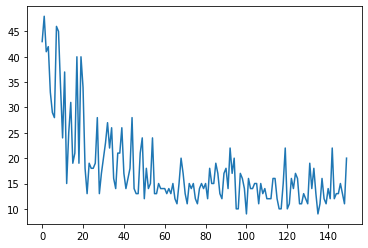

In [267]:
l = imps.nb_iteration_list
plt.plot(np.arange(len(l)),l)
print('nb iteration in total', np.sum(np.array(l)))

nb iteration in total 2895


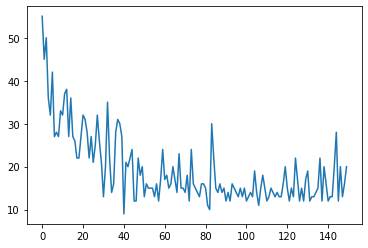

In [247]:
l = imps.nb_iteration_list
plt.plot(np.arange(len(l)),l)
print('nb iteration in total', np.sum(np.array(l)))

total time : 33.779764890670776


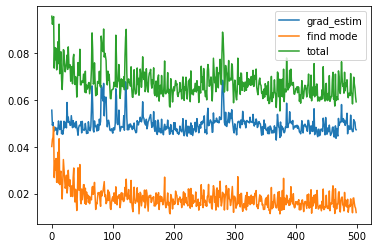

In [188]:
l_grad_estim = imps.t_grad_estim_list
l_mode = imps.t_mode_list
l_total = np.array(l_grad_estim) + np.array(l_mode)

plt.plot(np.arange(len(l_grad_estim)), l_grad_estim, label = 'grad_estim')
plt.plot(np.arange(len(l_mode)), l_mode, label = 'find mode')
plt.plot(np.arange(len(l_mode)), l_total, label = 'total')
plt.legend()
print('total time :', np.sum(l_total))

nb iteration in total 11995


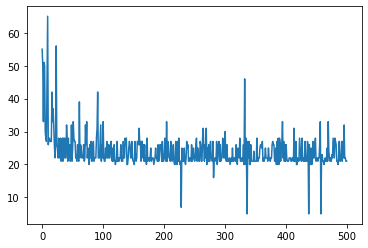

In [191]:
l = imps.nb_iteration_list
plt.plot(np.arange(len(l)),l)
print('nb iteration in total', np.sum(np.array(l)))

total time : 34.15247941017151


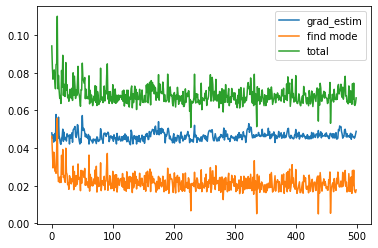

In [192]:
l_grad_estim = imps.t_grad_estim_list
l_mode = imps.t_mode_list
l_total = np.array(l_grad_estim) + np.array(l_mode)

plt.plot(np.arange(len(l_grad_estim)), l_grad_estim, label = 'grad_estim')
plt.plot(np.arange(len(l_mode)), l_mode, label = 'find mode')
plt.plot(np.arange(len(l_mode)), l_total, label = 'total')
plt.legend()
print('total time :', np.sum(l_total))


No handles with labels found to put in legend.
No handles with labels found to put in legend.


max likelihood : -103.72658217464168


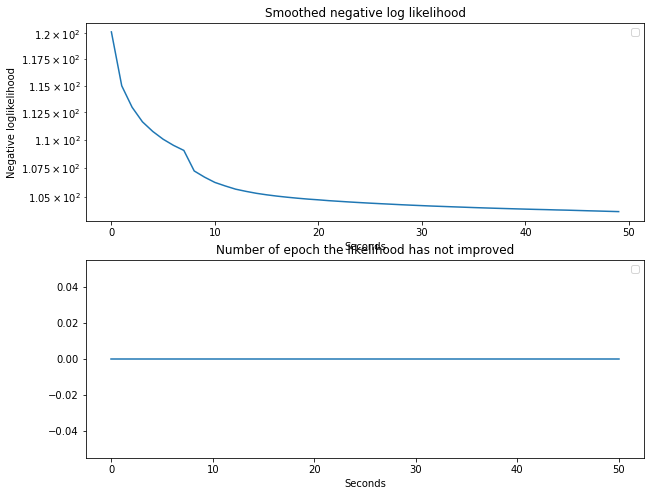

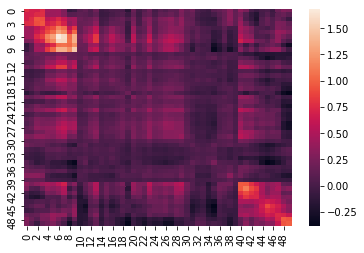

In [101]:
print(imps)

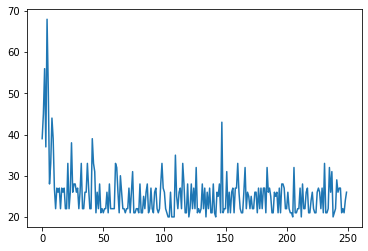

In [104]:
l = imps.nb_iteration_list
plt.plot(np.arange(len(l)),l)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


max likelihood : -103.48243696286471


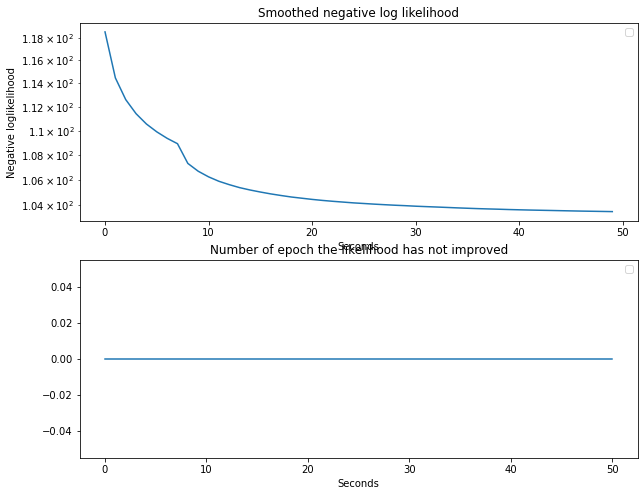

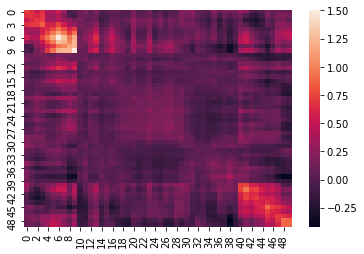

In [106]:
print(imps)

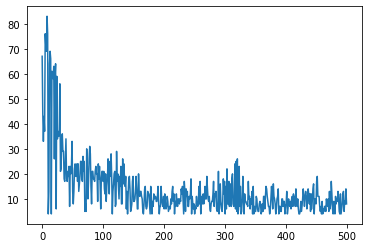

In [78]:
l = imps.nb_iteration_list
plt.plot(np.arange(len(l)),l)